In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [285]:
url= 'https://opendata.muenchen.de/dataset/5e73a82b-7cfb-40cc-9b30-45fe5a3fa24e/resource/40094bd6-f82d-4979-949b-26c8dc00b9a7/download/monatszahlen2510_verkehrsunfaelle_30_10_25.csv'
df = pd.read_csv(url)

In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MONATSZAHL                      2352 non-null   object 
 1   AUSPRAEGUNG                     2352 non-null   object 
 2   JAHR                            2352 non-null   int64  
 3   MONAT                           2352 non-null   object 
 4   WERT                            2268 non-null   float64
 5   VORJAHRESWERT                   2268 non-null   float64
 6   VERAEND_VORMONAT_PROZENT        2092 non-null   float64
 7   VERAEND_VORJAHRESMONAT_PROZENT  2183 non-null   float64
 8   ZWOELF_MONATE_MITTELWERT        2100 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 165.5+ KB


In [287]:
df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2025,202501,NaN,24.0,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2025,202502,NaN,28.0,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2025,202503,NaN,25.0,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2025,202504,NaN,38.0,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2025,202505,NaN,32.0,NaN,NaN,NaN


In [288]:
# Data Cleaning and Preprocessing

# Only these columns are relevant for us
df = df[['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT']]
df = df[df['AUSPRAEGUNG'] == 'insgesamt']
df = df.dropna()

# Let's remove the summary rows
df = df[df['MONAT'] != 'Summe']
df['DATE'] = pd.to_datetime(df['MONAT'].astype(str), format='%Y%m')

df['MONTH_NUM'] = df['MONAT'].astype(str).str[-2:].astype(int)

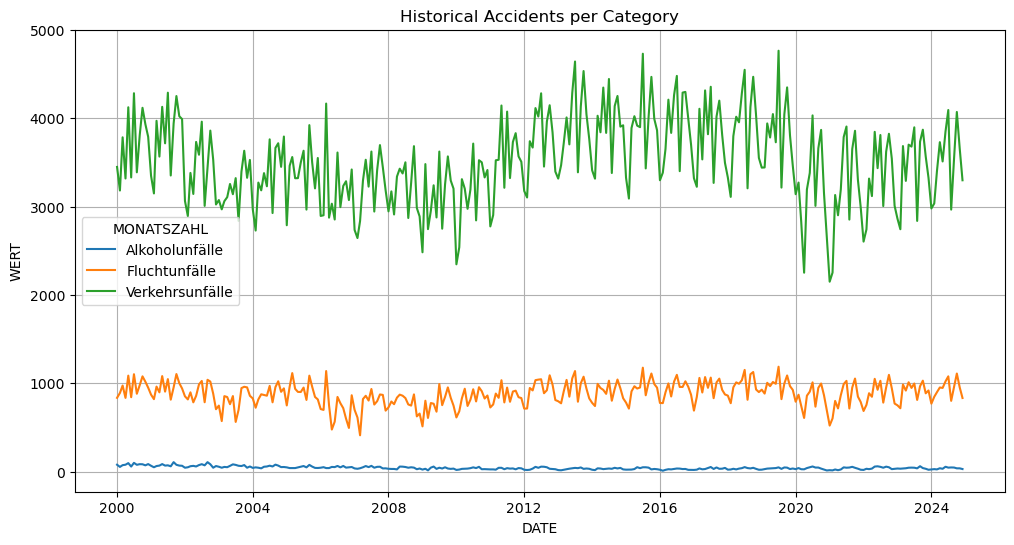

In [289]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='DATE', y='WERT', hue='MONATSZAHL')
plt.title('Historical Accidents per Category')
plt.grid(True)

In [291]:
# Filtering data for training
category = 'Alkoholunfälle'
accident_type = 'insgesamt'

dataset_filter = (df['MONATSZAHL'] == category) & (df['AUSPRAEGUNG'] == accident_type)

df_filtered = df[dataset_filter].copy()

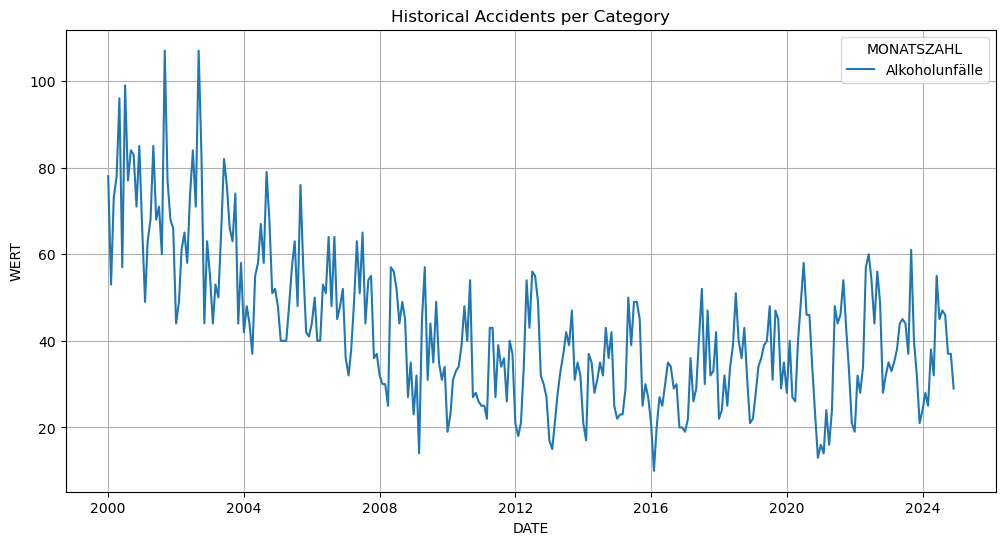

In [292]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_filtered, x='DATE', y='WERT', hue='MONATSZAHL')
plt.title('Historical Accidents per Category')
plt.grid(True)

In [293]:
train_data = df_filtered[df_filtered['JAHR'] <= 2020]
test_data = df_filtered[df_filtered['JAHR'] > 2020]

In [ ]:
X_train = train_data[['JAHR', 'MONTH_NUM']]
y_train = train_data['WERT']

X_test = test_data[['JAHR', 'MONTH_NUM']]
y_test = test_data['WERT']

Trees: 10 -> MAE: 8.15
Trees: 30 -> MAE: 7.81
Trees: 50 -> MAE: 7.81
Trees: 70 -> MAE: 7.78
Trees: 90 -> MAE: 7.75
Trees: 110 -> MAE: 7.91
Trees: 130 -> MAE: 7.97
Trees: 150 -> MAE: 7.97
Trees: 170 -> MAE: 7.95
Trees: 190 -> MAE: 7.94
Trees: 210 -> MAE: 7.92
Trees: 230 -> MAE: 7.91
Trees: 250 -> MAE: 7.87
Trees: 270 -> MAE: 7.84
Trees: 290 -> MAE: 7.82


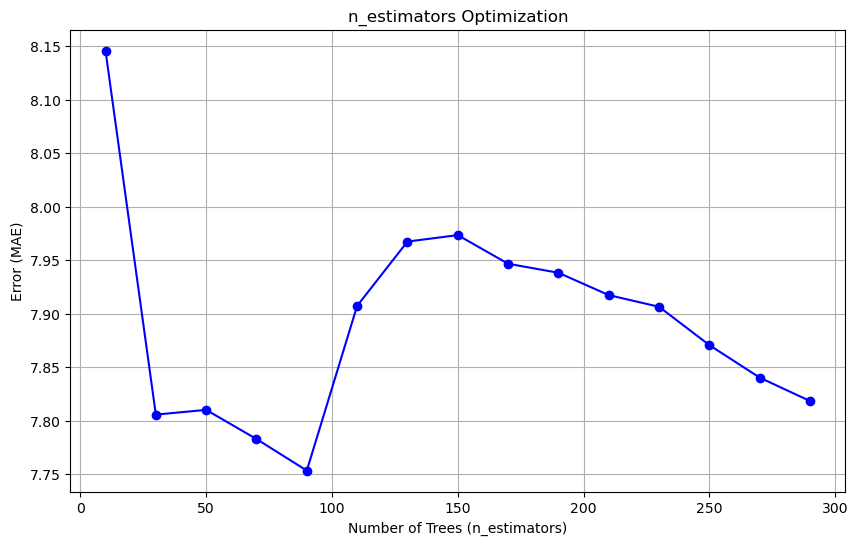

Best n_estimators (7.75 MAE): 90


In [316]:
n_estimators_list = list(range(10, 310, 20))
results = []

for n in n_estimators_list:
    model = RandomForestRegressor(n_estimators=n, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append(mae)
    print(f"Trees: {n} -> MAE: {mae:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, results, marker='o', linestyle='-', color='b')
plt.title('n_estimators Optimization')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Error (MAE)')
plt.grid(True)
plt.show()

best_n = n_estimators_list[results.index(min(results))]
print(f"Best n_estimators ({min(results):.2f} MAE): {best_n}")

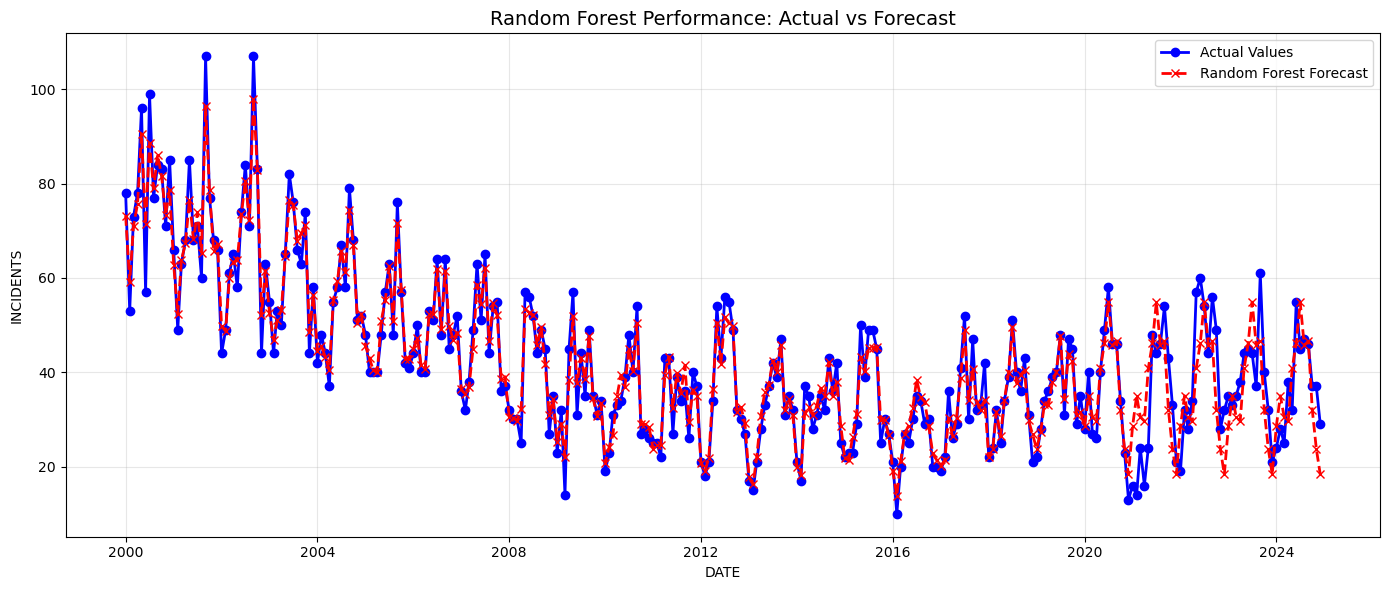

In [317]:
rf_model = RandomForestRegressor(n_estimators=90, random_state=42)
rf_model.fit(X_train, y_train)

X_all = pd.concat([X_train, X_test])
y_all = pd.concat([y_train, y_test])

y_pred_rf = rf_model.predict(X_all)
plot_data = X_all.copy()
plot_data['Actual'] = y_all
plot_data['Forecast'] = y_pred_rf
plot_data['DATE'] = pd.to_datetime(
    plot_data['JAHR'].astype(str) + "-" + plot_data['MONTH_NUM'].astype(str), 
    format='%Y-%m'
)

# Tarihe göre sıralayalım ki çizgiler karışmasın
plot_data = plot_data.sort_values('DATE')

# 3. Grafik Çizimi
# -----------------------------------------
plt.figure(figsize=(14, 6))

plt.plot(plot_data['DATE'], plot_data['Actual'], 
         label='Actual Values', 
         color='blue', marker='o', linewidth=2)

# Tahmin Değerleri (Kırmızı)
plt.plot(plot_data['DATE'], plot_data['Forecast'], 
         label='Random Forest Forecast', 
         color='red', linestyle='--', marker='x', linewidth=2)

# Başlık ve Etiketler
plt.title('Random Forest Performance: Actual vs Forecast', fontsize=14)
plt.xlabel('DATE')
plt.ylabel('INCIDENTS')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [315]:
MSE_VAL = mean_squared_error(y_test, rf_model.predict(X_test))
print(f"\nModel Mean Squared Error (MSE) on Test Set: {MSE_VAL:.2f}")


Model Mean Squared Error (MSE) on Test Set: 85.14


In [273]:
train_data = df_filtered[df_filtered['JAHR'] <= 2020].set_index('DATE').sort_index()
train_data = train_data[['WERT']]
test_data = df_filtered.set_index('DATE').sort_index()
test_data = test_data[['WERT']]

In [274]:
train_data

,WERT
DATE,
2001-01-01,66.0
2001-02-01,49.0
2001-03-01,63.0
2001-04-01,68.0
2001-05-01,85.0
...,...
2020-08-01,46.0
2020-09-01,46.0
2020-10-01,34.0


In [275]:
train_data

,WERT
DATE,
2001-01-01,66.0
2001-02-01,49.0
2001-03-01,63.0
2001-04-01,68.0
2001-05-01,85.0
...,...
2020-08-01,46.0
2020-09-01,46.0
2020-10-01,34.0


In [284]:
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 12
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

print(f"Toplam denenecek model sayısı: {len(pdq) * len(seasonal_pdq)}")
print("🚀 Grid Search Başlıyor... (Biraz zaman alabilir)")

# 2. GRID SEARCH DÖNGÜSÜ
# ---------------------------------------------------------
best_aic = float("inf")
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Modeli kur
            model = SARIMAX(train_data,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            
            results = model.fit(disp=False)
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                print(f"✅ Yeni En İyi Model Bulundu: ARIMAX{param}x{param_seasonal} - AIC:{best_aic:.2f}")
                
        except Exception as e:
            print(f"❌ Model ARIMAX{param}x{param_seasonal} kurulamadı: {e}")
            continue

print(f"🏆 KAZANAN MODEL:")
print(f"Order (p,d,q):          {best_params}")
print(f"Seasonal Order (P,D,Q): {best_seasonal_params}")
print(f"AIC Skoru:              {best_aic:.2f}")

Toplam denenecek model sayısı: 64
🚀 Grid Search Başlıyor... (Biraz zaman alabilir)
✅ Yeni En İyi Model Bulundu: ARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:2500.50
✅ Yeni En İyi Model Bulundu: ARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:2151.90
✅ Yeni En İyi Model Bulundu: ARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:1712.48


/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages

✅ Yeni En İyi Model Bulundu: ARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:1583.40


/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages

✅ Yeni En İyi Model Bulundu: ARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:1579.02


/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages

✅ Yeni En İyi Model Bulundu: ARIMAX(0, 0, 1)x(0, 1, 1, 12) - AIC:1550.58


/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages

✅ Yeni En İyi Model Bulundu: ARIMAX(0, 0, 1)x(1, 1, 1, 12) - AIC:1546.15


/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages

✅ Yeni En İyi Model Bulundu: ARIMAX(0, 1, 1)x(0, 1, 1, 12) - AIC:1502.70


/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages

✅ Yeni En İyi Model Bulundu: ARIMAX(0, 1, 1)x(1, 1, 1, 12) - AIC:1501.30


/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages

✅ Yeni En İyi Model Bulundu: ARIMAX(1, 1, 1)x(0, 1, 1, 12) - AIC:1499.33


/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages

✅ Yeni En İyi Model Bulundu: ARIMAX(1, 1, 1)x(1, 1, 1, 12) - AIC:1498.25
🏆 KAZANAN MODEL:
Order (p,d,q):          (1, 1, 1)
Seasonal Order (P,D,Q): (1, 1, 1, 12)
AIC Skoru:              1498.25


/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


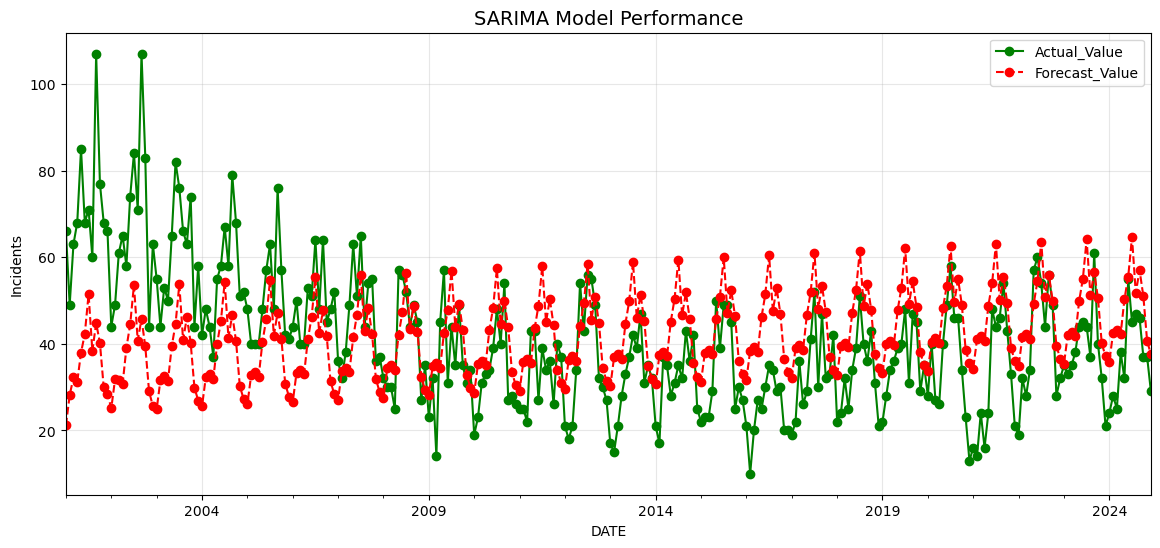

In [281]:
model = SARIMAX(
    train_data["WERT"],
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)

forecast = results.get_forecast(steps = len(test_data))
predictions = forecast.predicted_mean

predictions.index = test_data.index

forecast_df = pd.DataFrame({
    'DATE': predictions.index,
    'Actual_Value': test_data['WERT'].values,
    'Forecast_Value': predictions.values,
})

forecast_df = forecast_df.set_index('DATE')

forecast_df.plot(figsize=(14, 6), 
                 color=['green', 'red'], 
                 style=['-', '--'], 
                 marker='o')

plt.title('SARIMA Model Performance', fontsize=14)
plt.ylabel('Incidents')
plt.grid(True, alpha=0.3)
plt.show()

In [282]:
mse = mean_squared_error(forecast_df['Actual_Value'], forecast_df['Forecast_Value'])
print(f"\nSARIMA Model Mean Squared Error (MSE) on Test Set: {mse:.2f}")


SARIMA Model Mean Squared Error (MSE) on Test Set: 267.46


In [300]:
import joblib

joblib.dump(rf_model, 'traffic_accident_model.joblib')

print("✅ Model başarıyla paketlendi ve 'traffic_accident_model.joblib' olarak kaydedildi.")

✅ Model başarıyla paketlendi ve 'traffic_accident_model.joblib' olarak kaydedildi.
